## Loading modules, dataset and descriptions

In [1]:
# General Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sts
import warnings
from covid import plot_percentage_subplots, test_models_metrics, feature_select, best_classification_split_score

In [2]:
# Machine learning utils
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from pprint import pprint

In [3]:
%matplotlib inline
warnings.filterwarnings('ignore')

#### Loading 

In [4]:
# importing the dataset
ds = pd.read_csv('COVID.csv')
# droppping the column 'Unnamed: 0'
ds.drop(columns=['Unnamed: 0'], inplace = True)
ds.head()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,0,1,NaN,0.0,27,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN
1,0,1,NaN,0.0,24,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,NaN
2,1,0,0.0,0.0,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,1,0.0
3,0,0,0.0,1.0,30,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,0.0
4,1,0,0.0,0.0,60,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,1,0.0


In [5]:
# creating a dictionary with information on the features
desc = {
    'id': "Patient's ID", 'sex': 'Patient sex (0 - Male / 1 - Female)',
    'patient_type': 'Patient was hospitalized (1) or sent back home (0)',
    'intubed': 'Whether a patient was intubated (1) or not (0)', 'pneumonia': 'Whether a patient developed pneumonia (1) or not (0)',
    'age': "Patient's age", 'pregnancy': 'Whether a patient was pregnant (1) or not (0) (only females)',
    'diabetes': 'Was it a diabetic patient (1) or not (0)?', 'copd': 'Chronic obstructive pulmonary disease (COPD) (1) or not (0)',
    'asthma': 'Whether a patient has asthma (1) or not (0)', 'inmsupr': 'Patient immunosuppressed (1) or not (0)',
    'hypertension': 'Hypertense patient (1) or not (0)?', 'ohter_disease': 'Had othher diseases (1) or not (0)?',
    'cardiovascular': 'Cardiovascular diseases (1) or not (0)?', 'obesity': 'Obese (1) or not (0)?',
    'renal_chronic': 'Chronic kidney disease (1) or not (0)', 'tobacco': 'Smoker (1) or not (0)',
    'contact_other_covid': 'Patient made contact with a COVID-diagnosed person (1) or not (0)',
    'icu': 'Hospitalized in an intensive care unit (ICU) (1) or not (0)', 'covid_res': 'Tested positive for any COVID test (1) or not (0)'
}

# creating description for features
ds_desc = pd.Series(data=desc.values(), index=desc.keys())

## Data preparation and consistency

In [6]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499692 entries, 0 to 499691
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sex                  499692 non-null  int64  
 1   patient_type         499692 non-null  int64  
 2   intubed              107424 non-null  float64
 3   pneumonia            499681 non-null  float64
 4   age                  499692 non-null  int64  
 5   pregnancy            245258 non-null  float64
 6   diabetes             498051 non-null  float64
 7   copd                 498246 non-null  float64
 8   asthma               498250 non-null  float64
 9   inmsupr              498030 non-null  float64
 10  hypertension         498203 non-null  float64
 11  other_disease        497499 non-null  float64
 12  cardiovascular       498183 non-null  float64
 13  obesity              498222 non-null  float64
 14  renal_chronic        498216 non-null  float64
 15  tobacco          

In [7]:
# proportion of missing data
ds.isna().mean() * 100

sex                     0.000000
patient_type            0.000000
intubed                78.501957
pneumonia               0.002201
age                     0.000000
pregnancy              50.918166
diabetes                0.328402
copd                    0.289378
asthma                  0.288578
inmsupr                 0.332605
hypertension            0.297984
other_disease           0.438870
cardiovascular          0.301986
obesity                 0.294181
renal_chronic           0.295382
tobacco                 0.315995
contact_other_covid    30.753944
covid_res               0.000000
icu                    78.502157
dtype: float64

**Comments:** The columns 'intubed', 'pregnancy', 'icu' and 'contact_other_covid' have large percentage of missing values and a strategy is necessary to handle them. Other columns have small percentage of missing values and can be dealt by erasing these individuals from the analysis.

---
### Working missing data on the pregnancy column<br>
- Missing data will be randomly filled complying with the proportion males (0) and females (1) and age category

In [8]:
# creating a copy of the original dataset for manipulation
ds_clean = ds.copy()

In [9]:
# The majority of missing values on the pregnancy column belongs to males. Therefore, NaN can be safely filled with 0
ds_clean[ds_clean['pregnancy'].isna()]['sex'].value_counts()

0    253098
1      1336
Name: sex, dtype: int64

In [10]:
# Filling the missing values for males on the pregnancy column
index_males = ds_clean['pregnancy'][(ds_clean['sex'] == 0) & (ds_clean['pregnancy'].isna())].index
ds_clean.loc[index_males, 'pregnancy'] = 0

In [11]:
# There are some missing values between females that are out of age for natural pregnancy. Therefore, NaN will be filled with 0
ds_clean[ds_clean['pregnancy'].isna()].value_counts()
# Females of age over 50 years old were not considered as pregnant
ds_clean['pregnancy'][ds_clean['age'] >= 50] = 0

In [12]:
# About 99% of the females of age under 50 years old were not pregnant by the time of infection. Therefore, NaN values at this
# age range will be filled with 0
ds_clean['pregnancy'][ds_clean['age'] < 50].value_counts(normalize=True)
ds_clean['pregnancy'][(ds_clean['pregnancy'].isna()) & (ds_clean['age'] < 50)] = 0

---
### Working missing data on the contact_other_covid, intubed and icu columns<br>
- Missing data on the contact_other_covid will be dropped
- Intubed and icu columns will be utterly dropped

In [13]:
# filling NaN values on the 'icu' and 'intubed' columns with 0
ds_clean['icu'].fillna(value=0, inplace=True)
ds_clean['intubed'].fillna(value=0, inplace=True)

**Comments:** I suppose that NaN values on icu and itubed columns refer to patients that were not intubed or needed intensive care. Therefore, NaN values were filled with 0.

In [14]:
# dropping 'contact_other_covid' COVID columns since it has over 30% missing values and any reasonable way to fill them.
ds_clean.drop(columns=['contact_other_covid'], inplace=True)

**Comments:** I couldn't find a pattern to fill contact_other_covid columns. Therefore, it was dropped off of anlaysis.

### Dealing with the remnant missing data

In [15]:
# dropping the rows for which a few missing data are still found
ds_clean.dropna(inplace=True)
ds_clean.isna().sum()

sex               0
patient_type      0
intubed           0
pneumonia         0
age               0
pregnancy         0
diabetes          0
copd              0
asthma            0
inmsupr           0
hypertension      0
other_disease     0
cardiovascular    0
obesity           0
renal_chronic     0
tobacco           0
covid_res         0
icu               0
dtype: int64

---
### Other small assessment and modifications

In [16]:
# checking relationship between age and smoke
ds_clean['age'][(ds_clean['tobacco'] == 1) & (ds_clean['age'] <= 12)]

5856       1
41552      0
48457     12
64979      1
98347     11
          ..
462568     4
462746     1
470476    10
488937     0
490024     0
Name: age, Length: 76, dtype: int64

**Comments:** It wasn't clear whether patients under 12 years old were considered passive smokers or had it be mistakenly filled. Therefore, these few values will be replaced by 0.

In [17]:
# erasing the data of smokers that are younger than 13 years old
ds_clean['age'][(ds_clean['tobacco'] == 1) & (ds_clean['age'] <= 12)] = 0

## Exploratory data analysis

In [18]:
# Checking the dataset after changes
ds_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496291 entries, 0 to 499691
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sex             496291 non-null  int64  
 1   patient_type    496291 non-null  int64  
 2   intubed         496291 non-null  float64
 3   pneumonia       496291 non-null  float64
 4   age             496291 non-null  int64  
 5   pregnancy       496291 non-null  float64
 6   diabetes        496291 non-null  float64
 7   copd            496291 non-null  float64
 8   asthma          496291 non-null  float64
 9   inmsupr         496291 non-null  float64
 10  hypertension    496291 non-null  float64
 11  other_disease   496291 non-null  float64
 12  cardiovascular  496291 non-null  float64
 13  obesity         496291 non-null  float64
 14  renal_chronic   496291 non-null  float64
 15  tobacco         496291 non-null  float64
 16  covid_res       496291 non-null  int64  
 17  icu       

In [19]:
# Overview on the descriptive statistics of the dataset
ds_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,496291.0,0.494039,0.499965,0.0,0.0,0.0,1.0,1.0
patient_type,496291.0,0.786256,0.409948,0.0,1.0,1.0,1.0,1.0
intubed,496291.0,0.017707,0.131886,0.0,0.0,0.0,0.0,1.0
pneumonia,496291.0,0.156172,0.363019,0.0,0.0,0.0,0.0,1.0
age,496291.0,42.512486,16.624512,0.0,31.0,41.0,53.0,120.0
pregnancy,496291.0,0.007220,0.084661,0.0,0.0,0.0,0.0,1.0
diabetes,496291.0,0.124693,0.330371,0.0,0.0,0.0,0.0,1.0
copd,496291.0,0.016527,0.127489,0.0,0.0,0.0,0.0,1.0
asthma,496291.0,0.032513,0.177359,0.0,0.0,0.0,0.0,1.0
inmsupr,496291.0,0.016097,0.125850,0.0,0.0,0.0,0.0,1.0


In [20]:
# rationale: Patient age matters to COVID-19.
## Thus, a new column will be created based on information collected at https://www.cdc.gov/nchs/nvss/vsrr/covid_weekly/index.htm#SexAndAge
ds_clean.loc[ds_clean.age < 20, 'age_category'] = '19 or less'
ds_clean.loc[(ds_clean.age >= 20) & (ds_clean.age < 35), 'age_category'] = '20-34'
ds_clean.loc[(ds_clean.age >= 35) & (ds_clean.age < 50), 'age_category'] = '35-49'
ds_clean.loc[(ds_clean.age >= 50) & (ds_clean.age < 65), 'age_category'] = '50-64'
ds_clean.loc[(ds_clean.age >= 65) & (ds_clean.age < 75), 'age_category'] = '65-74'
ds_clean.loc[(ds_clean.age >= 75) & (ds_clean.age < 85), 'age_category'] = '75-84'
ds_clean.loc[ds_clean['age_category'].isna(), 'age_category'] = '85 or more'

In [21]:
# creating a dictionary with information on the features
legend_label = {
        'sex': {0: 'male', 1: 'female'}, 'patient_type': {0: 'home', 1: 'hospitalized'}, 'intubed': {0: 'no', 1: 'yes'},
        'pneumonia': {0: 'no', 1: 'yes'}, 'diabetes': {0: 'no', 1: 'yes'}, 'copd': {0: 'no', 1: 'yes'}, 
        'asthma': {0: 'no', 1: 'yes'}, 'inmsupr': {0: 'no', 1: 'yes'}, 'hypertension': {0: 'no', 1: 'yes'}, 
        'other_disease': {0: 'no', 1: 'yes'}, 'cardiovascular': {0: 'no', 1: 'yes'}, 'obesity': {0: 'regular', 1: 'obese'},
        'renal_chronic': {0: 'no', 1: 'yes'}, 'tobacco': {0: 'no', 1: 'yes'}, 'covid_res': {0: 'negative', 1: 'positive'}, 
        'icu': {0: 'regular care', 1: 'intensive care'}}

##########################################################################################################################
############ ABSOLUTE FREQUENC BY AGE RANGE ######################### RELATIVE FREQUENCY BY AGE RANGE ####################
##########################################################################################################################


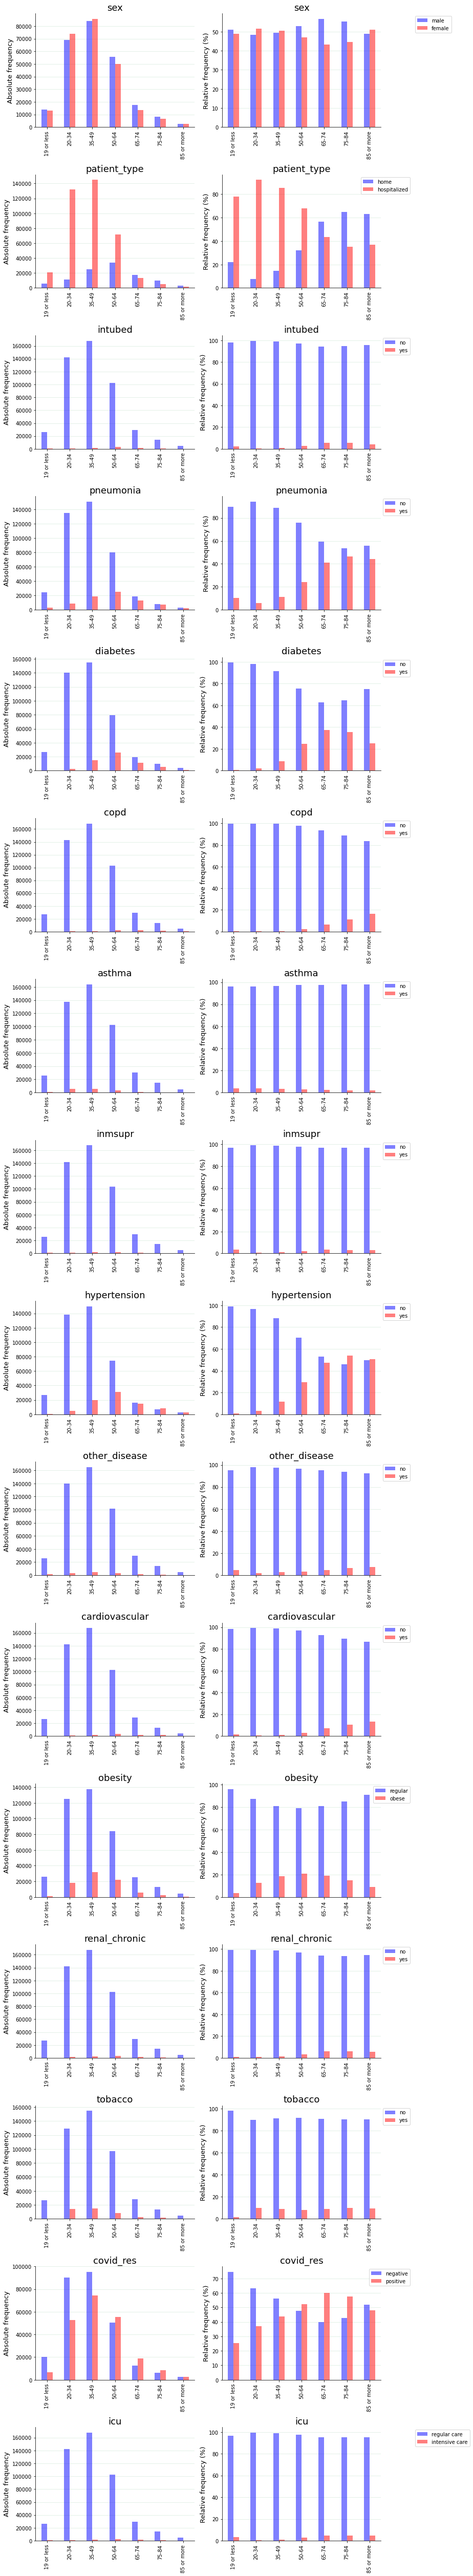

In [22]:
# Evaluating absolute and relative frequencies of patients by age range and feature
## General, customized title
print(f'{"#" * 122}\n{("#" * 12) + " ABSOLUTE FREQUENC BY AGE RANGE " + ("#" * 25) + " RELATIVE FREQUENCY BY AGE RANGE " + ("#" * 20)}\n{"#" * 122}')

## Plots through looping
cols = ds_clean.columns
col1, col2, col3 = np.where(cols == 'age'), np.where(cols == 'pregnancy'), np.where(cols == 'age_category')
columns = np.delete(cols, [col1, col2, col3])
nrows = len(columns)
ncols = 2

plt.figure(figsize=(13,70))
num = 0

for index in range(nrows):
    ax1 = plt.subplot2grid(shape = (nrows, ncols), loc = (index, num))
    ax2 = plt.subplot2grid(shape = (nrows, ncols), loc = (index, (num + 1)))
    legend = [legend_label[columns[index]].get(0), legend_label[columns[index]].get(1)]
    plot_percentage_subplots(ds_clean, columns[index], 'age_category', normalize=False, ax = ax1, legend=False, color=['b', 'r'])
    plot_percentage_subplots(ds_clean, columns[index], 'age_category', normalize=True, legend_label=legend, ax = ax2, color=['b', 'r'])
    
plt.tight_layout()
#plt.savefig('frequencies_on_dataset.jpg', dpi=300)

plt.show()


**Comments:** Stratification by age showed that:
- patient_type: The younger the patient the more likely to stay at the hospital and receive medical assistance.
- pneumoina: It was commoner in patients older that 50 years old
- diabetes and hypertension: As expected, the older the patient the more likely to have diabetes.
- covid_res: The older the patient the more likely to have a positive results on the covid tests. Maybe the virus has different multiplication curves between youngsters and elders?

---
## Machine learning models for COVID-19 diagnosis

In [23]:
# creating copy of the dataframe for edition
df = ds_clean.copy()
df.head()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,covid_res,icu,age_category
0,0,1,0.0,0.0,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,20-34
1,0,1,0.0,0.0,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,20-34
2,1,0,0.0,0.0,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,50-64
3,0,0,0.0,1.0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,20-34
4,1,0,0.0,0.0,60,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,50-64


In [24]:
# quantity and proportion of each class on the target column
ab = df['covid_res'].value_counts(normalize=False).sort_index()
rel = df['covid_res'].value_counts(normalize=True).sort_index() * 100
print(f"On the dataset, {ab[0]} people ({round(rel[0], 2)}%) were diagnosed negative for COVID-19, while {ab[1]} were positives ({round(rel[1], 2)}%).")

On the dataset, 277389 people (55.89%) were diagnosed negative for COVID-19, while 218902 were positives (44.11%).


#### Overall testing with several models

In [32]:
# Selecting feature and taget variables
X = df.drop(columns=['covid_res', 'age_category'])
y = df['covid_res']
stratify = df['covid_res']
# splitting 
X_train, X_test_val, y_train, y_test_val = train_test_split(X,
                                                            y,
                                                            test_size=0.5,
                                                            random_state=42,
                                                            stratify=stratify)
X_test, X_validation, y_test, y_validation = train_test_split(X_test_val,
                                                              y_test_val,
                                                              test_size=0.5,
                                                              random_state=42,
                                                              stratify=y_test_val)
# scaling data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_validation = sc.transform(X_validation)

In [38]:
# models
list_models = [
{'model_name': 'Logistic Regression',
 'estimator' : LogisticRegression(random_state=42)},
{'model_name': 'Tree classification',
 'estimator' : DecisionTreeClassifier(random_state=42)},
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state=42)},
{'model_name': 'AdaBoost',
 'estimator' : AdaBoostClassifier(random_state=42)},
{'model_name': 'Gradient Boosting Classifier',
 'estimator' : GradientBoostingClassifier(random_state=42)},
{'model_name': 'XGB_Classifier',
 'estimator' : XGBClassifier(random_state=42)},
{'model_name': 'LightGBM',
 'estimator' : lgb.LGBMClassifier(random_state=42)},
]

Cross-validation: [0.6311 0.6338 0.6311 0.6287 0.6314]
Mean: 0.6312
Standard deviation: 0.0016
Model      : Logistic Regression
Accuracy   : 0.6303 
Precision  : 0.6342 
Recall     : 0.6303 
F1 - Score : 0.6052 
F1 - Score for class 0: 0.72
F1 - Score for class 1: 0.46
ROC - AUC  : 0.6018 
Cross-validation: [0.6212 0.625  0.6206 0.6182 0.6204]
Mean: 0.6211
Standard deviation: 0.0022
Model      : Tree classification
Accuracy   : 0.6218 
Precision  : 0.6258 
Recall     : 0.6218 
F1 - Score : 0.5927 
F1 - Score for class 0: 0.72
F1 - Score for class 1: 0.44
ROC - AUC  : 0.5914 
Cross-validation: [0.6227 0.6263 0.622  0.6203 0.6229]
Mean: 0.6228
Standard deviation: 0.002
Model      : Random Forest
Accuracy   : 0.6230 
Precision  : 0.6257 
Recall     : 0.6230 
F1 - Score : 0.5963 
F1 - Score for class 0: 0.71
F1 - Score for class 1: 0.45
ROC - AUC  : 0.5938 
Cross-validation: [0.6339 0.6365 0.6347 0.6309 0.633 ]
Mean: 0.6338
Standard deviation: 0.0019
Model      : AdaBoost
Accuracy   : 0.63

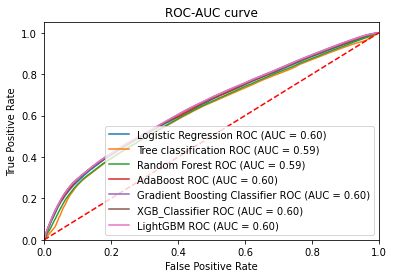

In [39]:
# evaluating metrics
test_models_metrics(X, y, list_models, 'model_name', 'estimator', cross_validation_split_number=5, save_fig=False,
                    stratify=stratify)

**Comments:** It looks like boosting methods handled the dataset better, though differences were at the floating point for most of them. It's noteworthy that logistic regression, the simplest tested model, did very well and will be used in this study. KNN classifier took a long while to run so it will be analysed later on this notebook. Conclusions were taken based on ROC - AUC values and f1_score.

#### Testing feature selection

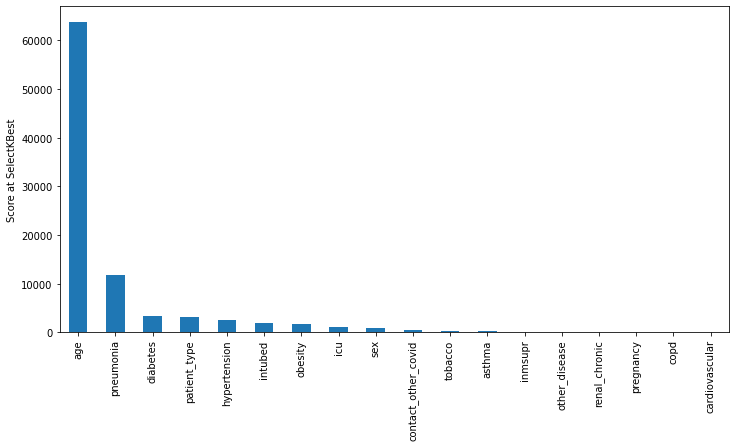


################################################################################################


age                    63771.636195
pneumonia              11861.765182
diabetes                3288.765322
patient_type            3088.959508
hypertension            2532.369627
intubed                 1937.087763
obesity                 1749.331019
icu                     1079.078552
sex                      881.461971
contact_other_covid      574.257961
tobacco                  238.107552
asthma                   214.278433
inmsupr                  112.187155
other_disease             41.453861
renal_chronic             36.510124
pregnancy                 29.127567
copd                      17.248087
cardiovascular             3.412347
dtype: float64

In [35]:
# selecting features based on chi-square test
X = df.drop(columns=['covid_res', 'age_category'])
y = df['covid_res']
selected_features = feature_select(X, y, score_func='chi_square')

# plotting the results
plt.figure(figsize=(12, 6))
selected_features.plot(kind='bar')
plt.ylabel('Score at SelectKBest')
plt.show()
print('\n################################################################################################')
display(selected_features)

In [29]:
# testing using only the most relevant features (only those with scores above 1000)
X = df[['age', 'pneumonia', 'diabetes', 'patient_type', 'hypertension', 'intubed', 'obesity', 'icu']]
y = df['covid_res']
stratify = df['covid_res']
# splitting 
X_train, X_test_val, y_train, y_test_val = train_test_split(X,
                                                            y,
                                                            test_size=0.5,
                                                            random_state=42,
                                                            stratify=stratify)
X_test, X_validation, y_test, y_validation = train_test_split(X_test_val,
                                                              y_test_val,
                                                              test_size=0.5,
                                                              random_state=42,
                                                              stratify=y_test_val)
# scaling data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_validation = sc.transform(X_validation)

Cross-validation: [0.6254 0.6281 0.627 ]
Mean: 0.6268
Standard deviation: 0.0011
Model      : Logistic Regression
Accuracy   : 0.6251 
Precision  : 0.6300 
Recall     : 0.6251 
F1 - Score : 0.5963 
F1 - Score for class 0: 0.72
F1 - Score for class 1: 0.44
ROC - AUC  : 0.5947 
Cross-validation: [0.6248 0.6279 0.6268]
Mean: 0.6265
Standard deviation: 0.0013
Model      : Tree classification
Accuracy   : 0.6270 
Precision  : 0.6353 
Recall     : 0.6270 
F1 - Score : 0.5950 
F1 - Score for class 0: 0.72
F1 - Score for class 1: 0.43
ROC - AUC  : 0.5951 
Cross-validation: [0.6253 0.6286 0.6283]
Mean: 0.6274
Standard deviation: 0.0015
Model      : Random Forest
Accuracy   : 0.6274 
Precision  : 0.6346 
Recall     : 0.6274 
F1 - Score : 0.5968 
F1 - Score for class 0: 0.72
F1 - Score for class 1: 0.44
ROC - AUC  : 0.5961 
Cross-validation: [0.6292 0.632  0.6319]
Mean: 0.631
Standard deviation: 0.0013
Model      : AdaBoost
Accuracy   : 0.6302 
Precision  : 0.6376 
Recall     : 0.6302 
F1 - Score

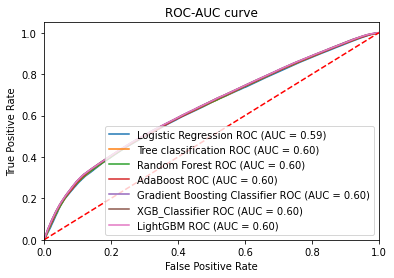

In [38]:
# evaluating metrics
test_models_metrics(X, y, list_models, 'model_name', 'estimator', cross_validation_split_number=3, save_fig=False,
                    stratify=stratify)

**Comments:** Since only a small difference in ROC - AUC and f1_score were abserved when selected features only were used, we will compare performance of models with total and selected features to make sure which one to use. It's noteworthy that if no difference is observed, it's better to use this reduced model for computational power issues.

##### Testing the ROC - AUC by statistics

In [33]:
# Setting variables for X with all features
X_total = df.drop(columns=['covid_res', 'age_category'])
y_total = df['covid_res']
stratify_total = df['covid_res']

# splitting total
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_total,
                                                            y_total,
                                                            test_size=0.5,
                                                            random_state=42,
                                                            stratify=stratify_total)
# scaling data
sc = StandardScaler()
X_train_t = sc.fit_transform(X_train_t)
X_test_t = sc.transform(X_test_t)

In [34]:
# Setting variables for X with selected features
X_selected = df[['age', 'pneumonia', 'diabetes', 'patient_type', 'hypertension', 'intubed', 'obesity', 'icu']]
y_selected = df['covid_res']
stratify_selected = df['covid_res']

# splitting total
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_selected,
                                                            y_selected,
                                                            test_size=0.5,
                                                            random_state=42,
                                                            stratify=stratify_selected)
# scaling data
sc = StandardScaler()
X_train_s = sc.fit_transform(X_train_s)
X_test_s = sc.transform(X_test_s)

In [36]:
# deploying the model and gathering results
model = LogisticRegression(random_state=42)

# randomly stratifying the datasets into 15 splits
skf_t = StratifiedKFold(n_splits = 15)
skf_s = StratifiedKFold(n_splits = 15)

# cross-validation of the model
## all features
cvt_auc = cross_val_score(model, X_train_t, y_train_t, scoring='roc_auc', cv = skf_t, n_jobs=-1)
## selected features
cvt_auc = cross_val_score(model, X_train_s, y_train_s, scoring='roc_auc', cv = skf_s, n_jobs=-1)

In [80]:
# running t-student test
## checking variances
var_cvt_auc, var_cvs_auc = np.var(cvt_auc), np.var(cvs_auc)
print(f"Variances for roc_auc scores are the same? {np.around(var_cvt_auc) == np.around(var_cvs_auc)}")

## running t-test for roc_auc values
_, roc_auc_ttest = sts.ttest_ind(cvt_auc, cvt_auc)

## display
print(f"Are ROC_AUC mean values between total and selected features different? {roc_auc_ttest < 0.05}")

Variances for roc_auc scores are the same? True
Are ROC_AUC mean values between total and selected features different? False


**Comments:** Since there is no significant difference in the ROA_AUC values between using all features or the most relevant to this model at a 95% confidence interval, only those most relevant were used for predictions.

#### Working the selected models

In [25]:
# testing using only the most relevant features (only those with scores above 1000)
X = df[['age', 'pneumonia', 'diabetes', 'patient_type', 'hypertension', 'intubed', 'obesity', 'icu']]
y = df['covid_res']
stratify = df['covid_res']
# splitting 
X_train, X_test_val, y_train, y_test_val = train_test_split(X,
                                                            y,
                                                            test_size=0.5,
                                                            random_state=42,
                                                            stratify=stratify)
X_test, X_validation, y_test, y_validation = train_test_split(X_test_val,
                                                              y_test_val,
                                                              test_size=0.5,
                                                              random_state=42,
                                                              stratify=y_test_val)
# scaling data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_validation = sc.transform(X_validation)

##### Logistic regression improvment

In [57]:
%%time
# parameter grid
## penalty
l1_ratio = [(x/10) for x in range(0, 11, 2)]

## Inverse of regularization strength
C = [1.0, 0.1, 0.01, 0.001, 0.0001]

## solver
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

## class weight
class_weight = ['balanced', None]

## creating a random grid
param_distributions = {"l1_ratio":l1_ratio,
                       'C': C,
                       'solver':solver,
                       'class_weight':class_weight}

## model
model = LogisticRegression(random_state=42)

## display
pprint(param_distributions)

## setting rendomized search
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_distributions,
                                   scoring='f1',
                                   n_iter = 100, 
                                   cv = 3, 
                                   verbose=2,
                                   n_jobs = -1,
                                   random_state=42)

# testing
random_search.fit(X_train, y_train)

{'C': [1.0, 0.1, 0.01, 0.001, 0.0001],
 'class_weight': ['balanced', None],
 'l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 3min 29s


RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [1.0, 0.1, 0.01, 0.001, 0.0001],
                                        'class_weight': ['balanced', None],
                                        'l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8,
                                                     1.0],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, scoring='f1', verbose=2)

In [59]:
# summary table with results sorted from the best ranked parameters
table_results = pd.DataFrame(random_search.cv_results_)
table_results_sorted = table_results.sort_values(by='rank_test_score')
table_results_sorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_l1_ratio,param_class_weight,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
51,3.022807,0.054992,0.074665,0.005558,saga,0.8,balanced,0.01,"{'solver': 'saga', 'l1_ratio': 0.8, 'class_wei...",0.515238,0.511323,0.515907,0.514156,0.002022,1
74,4.564714,0.008831,0.109991,0.007788,saga,0.2,balanced,0.01,"{'solver': 'saga', 'l1_ratio': 0.2, 'class_wei...",0.515238,0.511323,0.515907,0.514156,0.002022,1
83,4.812544,0.246470,0.084995,0.012193,saga,0.0,balanced,0.01,"{'solver': 'saga', 'l1_ratio': 0.0, 'class_wei...",0.515238,0.511323,0.515907,0.514156,0.002022,1
18,3.738766,0.275582,0.080328,0.007316,sag,1.0,balanced,0.01,"{'solver': 'sag', 'l1_ratio': 1.0, 'class_weig...",0.515238,0.511323,0.515907,0.514156,0.002022,1
71,0.590296,0.006236,0.067329,0.000472,lbfgs,0.2,balanced,0.01,"{'solver': 'lbfgs', 'l1_ratio': 0.2, 'class_we...",0.515238,0.511323,0.515907,0.514156,0.002022,1


In [60]:
# mean scoring value
f1_score_random = random_search.cv_results_['mean_test_score']
mean_f1_score_random = f1_score_random[~np.isnan(f1_score_random)].mean()
print("Mean_F1_score: ", np.around(mean_f1_score_random, 2))
best_param_random = random_search.best_params_
print("Best parameters: ", best_param_random)

Mean_F1_score:  0.47
Best parameters:  {'solver': 'sag', 'l1_ratio': 1.0, 'class_weight': 'balanced', 'C': 0.01}


In [61]:
# deploying model
model = LogisticRegression(solver='sag',
                           l1_ratio=1.0,
                           class_weight='balanced',
                           C=0.01,
                           random_state=42)
model.fit(X_train, y_train)
# working out prediction
y_proba = model.predict_proba(X_test)[:, 1]
results_test = pd.DataFrame(zip(y_test, np.around(y_proba, 3)), columns=['target', 'proba'])
df_results = best_classification_split_score(results_test, threshold_increment=0.02,colum_probabilities='proba')
# organizing values on a dataframe
df_results.sort_values(by=['f1_score', 'f0_score'], ascending=False)

0.02 0.04 0.06 0.08 0.1 0.12 0.14 0.16 0.18 0.2 0.22 0.24 0.26 0.28 0.3 0.32 0.34 0.36 0.38 0.4 0.42 0.44 0.46 0.48 0.5 0.52 0.54 0.56 0.58 0.6 0.62 0.64 0.66 0.68 0.7 0.72 0.74 0.76 0.78 0.8 0.82 0.84 0.86 0.88 0.9 0.92 0.94 0.96 0.98 1.0 

,threshold,TN,FN,FP,TP,precision,recall,accuracy,f0_score,f1_score
17,0.36,2866,1008,66481,53718,0.4469,0.9816,0.4561,0.0783,0.6142
16,0.34,1576,439,67771,54287,0.4448,0.9920,0.4502,0.0442,0.6142
18,0.38,7531,3177,61816,51549,0.4547,0.9419,0.4762,0.1881,0.6133
15,0.32,611,155,68736,54571,0.4426,0.9972,0.4448,0.0174,0.6130
0,0.02,0,0,69347,54726,0.4411,1.0000,0.4411,0.0000,0.6122
1,0.04,0,0,69347,54726,0.4411,1.0000,0.4411,0.0000,0.6122
2,0.06,0,0,69347,54726,0.4411,1.0000,0.4411,0.0000,0.6122
3,0.08,0,0,69347,54726,0.4411,1.0000,0.4411,0.0000,0.6122
4,0.10,0,0,69347,54726,0.4411,1.0000,0.4411,0.0000,0.6122
5,0.12,0,0,69347,54726,0.4411,1.0000,0.4411,0.0000,0.6122


**Comments:** The best f1_score is achieved when the threshold varies between 0.32 and 0.38.

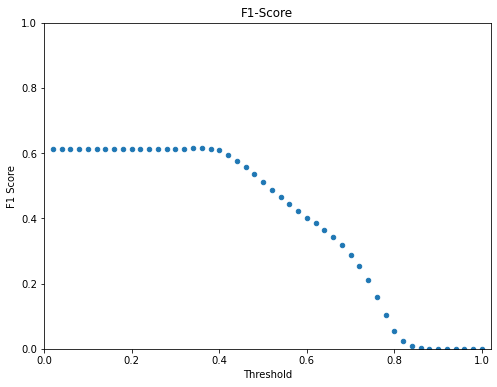

In [62]:
# Curva F1-Score

# Cria o plot
grap = df_results[df_results["threshold"] > 0.0].plot(kind="scatter", 
                                                         x="threshold", 
                                                         y="f1_score", 
                                                         grid=False, 
                                                         legend=True, 
                                                         title="F1-Score",
                                                         figsize=[8,6])
# Configurações do gráfico
grap.set(xlabel="Threshold", 
            ylabel="F1 Score", 
            xlim=(0.0,1.02), 
            ylim=(0.0,1.0))

# mostra o gráfico
plt.show()

Class report test
               precision    recall  f1-score   support

           0       0.56      0.09      0.15     69347
           1       0.44      0.91      0.60     54726

    accuracy                           0.45    124073
   macro avg       0.50      0.50      0.37    124073
weighted avg       0.51      0.45      0.35    124073



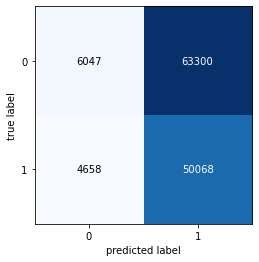


 Class report validation
               precision    recall  f1-score   support

           0       0.56      0.09      0.15     69347
           1       0.44      0.91      0.60     54726

    accuracy                           0.45    124073
   macro avg       0.50      0.50      0.37    124073
weighted avg       0.51      0.45      0.35    124073



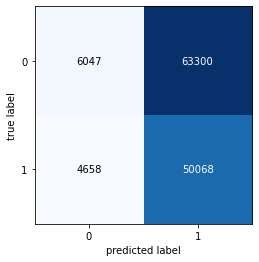

In [63]:
# prediction validation
y_proba_val = y_proba = model.predict_proba(X_validation)[:, 1]
# Cria a resposta com o novo threshold
y_pred_test = np.where(y_proba >= 0.32, 1, 0)
y_pred_val = np.where(y_proba_val >= 0.32, 1, 0)

# metrics
cr_test, cm_test = classification_report(y_test, y_pred_test), confusion_matrix(y_test, y_pred_test)
cr_val, cm_val = classification_report(y_test, y_pred_val), confusion_matrix(y_test, y_pred_val)
print('Class report test\n',cr_test)
plot_confusion_matrix(cm_test)
plt.show()

print('\n', 'Class report validation\n', cr_val)
plot_confusion_matrix(cm_val)

plt.show()

**Comments:** Using threshold of 0.32 it's possible to increase recall (find the true positives in the sample) to 0.99.

##### Adaboosting improvement

In [71]:
%%time
# parameter grid
## n_estimators 
n_estimators = [50, 250, 500]

## learning_rate
learning_rate = [0.01, 0.1, 1, 10]

## creating a random grid
param_distributions = {"n_estimators":n_estimators,
                       'learning_rate': learning_rate}

## model
model = AdaBoostClassifier(random_state=42)

## display
pprint(param_distributions)

## setting the randomized search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_distributions,
                                   scoring='f1',
                                   n_iter = 100, 
                                   cv = kfold, 
                                   verbose=5,
                                   n_jobs = -1,
                                   random_state=42)

# running test
random_search.fit(X_train, y_train)

{'learning_rate': [0.01, 0.1, 1, 10], 'n_estimators': [50, 250, 500]}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Wall time: 31min 12s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
                   estimator=AdaBoostClassifier(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 1, 10],
                                        'n_estimators': [50, 250, 500]},
                   random_state=42, scoring='f1', verbose=5)

In [72]:
# summary table with results sorted from the best ranked parameters
table_results = pd.DataFrame(random_search.cv_results_)
table_results_sorted = table_results.sort_values(by='rank_test_score')
table_results_sorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,22.611821,0.212235,1.295157,0.125263,50,10,"{'n_estimators': 50, 'learning_rate': 10}",0.498567,0.498919,0.494946,0.496150,0.497358,0.497188,0.001485,1
10,106.562762,6.253342,6.345149,0.280971,250,10,"{'n_estimators': 250, 'learning_rate': 10}",0.498567,0.498919,0.494946,0.496150,0.497358,0.497188,0.001485,1
11,192.044934,24.424574,9.795787,2.353926,500,10,"{'n_estimators': 500, 'learning_rate': 10}",0.498567,0.498919,0.494946,0.496150,0.497358,0.497188,0.001485,1
8,220.288315,0.254957,12.349861,0.526008,500,1,"{'n_estimators': 500, 'learning_rate': 1}",0.440271,0.443756,0.449725,0.451586,0.450543,0.447176,0.004397,4
7,109.982106,0.485327,6.141639,0.189762,250,1,"{'n_estimators': 250, 'learning_rate': 1}",0.440956,0.443837,0.449037,0.450490,0.450524,0.446969,0.003880,5


In [73]:
# mean scoring value
f1_score_random = random_search.cv_results_['mean_test_score']
mean_f1_score_random = f1_score_random[~np.isnan(f1_score_random)].mean()
print("Mean_F1_score: ", np.around(mean_f1_score_random, 2))
best_param_random = random_search.best_params_
print("Best parameters: ", best_param_random)

Mean_F1_score:  0.46
Best parameters:  {'n_estimators': 50, 'learning_rate': 10}


In [74]:
# testing parameters
#ada = AdaBoostClassifier(n_estimators=250, learning_rate=0.2)
model = AdaBoostClassifier(n_estimators=50,
                           learning_rate=10,
                           random_state=42)
model.fit(X_train, y_train)
# working out prediction
y_proba = model.predict_proba(X_test)[:, 1]
results_test = pd.DataFrame(zip(y_test, np.around(y_proba, 3)), columns=['target', 'proba'])
df_results = best_classification_split_score(results_test, threshold_increment=0.02,colum_probabilities='proba')
# organizing values on a dataframe
df_results.sort_values(by=['f1_score', 'f0_score'], ascending=False)

0.02 0.04 0.06 0.08 0.1 0.12 0.14 0.16 0.18 0.2 0.22 0.24 0.26 0.28 0.3 0.32 0.34 0.36 0.38 0.4 0.42 0.44 0.46 0.48 0.5 0.52 0.54 0.56 0.58 0.6 0.62 0.64 0.66 0.68 0.7 0.72 0.74 0.76 0.78 0.8 0.82 0.84 0.86 0.88 0.9 0.92 0.94 0.96 0.98 1.0 

,threshold,TN,FN,FP,TP,precision,recall,accuracy,f0_score,f1_score
0,0.02,0,0,69347,54726,0.4411,1.000,0.4411,0.0000,0.6122
1,0.04,0,0,69347,54726,0.4411,1.000,0.4411,0.0000,0.6122
2,0.06,0,0,69347,54726,0.4411,1.000,0.4411,0.0000,0.6122
3,0.08,0,0,69347,54726,0.4411,1.000,0.4411,0.0000,0.6122
4,0.10,0,0,69347,54726,0.4411,1.000,0.4411,0.0000,0.6122
5,0.12,0,0,69347,54726,0.4411,1.000,0.4411,0.0000,0.6122
6,0.14,0,0,69347,54726,0.4411,1.000,0.4411,0.0000,0.6122
7,0.16,0,0,69347,54726,0.4411,1.000,0.4411,0.0000,0.6122
8,0.18,0,0,69347,54726,0.4411,1.000,0.4411,0.0000,0.6122
9,0.20,0,0,69347,54726,0.4411,1.000,0.4411,0.0000,0.6122


**Comments:** All values between 0.02 and 0.46 generates the same precision (0.4411), recall (1.0) and f1_score (0.6122).

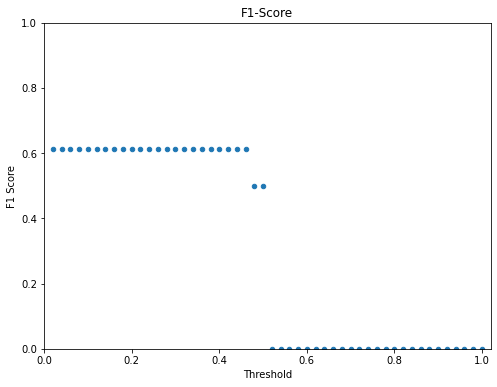

In [75]:
# Curva F1-Score

# Cria o plot
grap = df_results[df_results["threshold"] > 0.0].plot(kind="scatter", 
                                                         x="threshold", 
                                                         y="f1_score", 
                                                         grid=False, 
                                                         legend=True, 
                                                         title="F1-Score",
                                                         figsize=[8,6])
# Configurações do gráfico
grap.set(xlabel="Threshold", 
            ylabel="F1 Score", 
            xlim=(0.0,1.02), 
            ylim=(0.0,1.0))

# mostra o gráfico
plt.show()

Class report test
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     69347
           1       0.44      1.00      0.61     54726

    accuracy                           0.44    124073
   macro avg       0.22      0.50      0.31    124073
weighted avg       0.19      0.44      0.27    124073



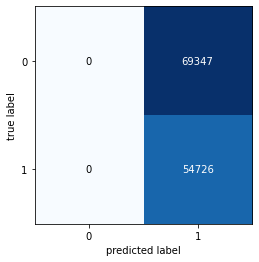


 Class report validation
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     69347
           1       0.44      1.00      0.61     54726

    accuracy                           0.44    124073
   macro avg       0.22      0.50      0.31    124073
weighted avg       0.19      0.44      0.27    124073



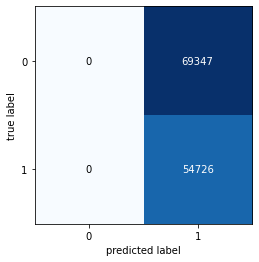

In [76]:
# prediction validation
y_proba_val = y_proba = model.predict_proba(X_validation)[:, 1]
# Cria a resposta com o novo threshold
y_pred_test = np.where(y_proba >= 0.4, 1, 0)
y_pred_val = np.where(y_proba_val >= 0.4, 1, 0)

# metrics
cr_test, cm_test = classification_report(y_test, y_pred_test), confusion_matrix(y_test, y_pred_test)
cr_val, cm_val = classification_report(y_test, y_pred_val), confusion_matrix(y_test, y_pred_val)
print('Class report test\n',cr_test)
plot_confusion_matrix(cm_test)
plt.show()

print('\n', 'Class report validation\n', cr_val)
plot_confusion_matrix(cm_val)

plt.show()

**Comments:** Using 0.4 as threshold a recall of 1, f1-score of 0.61 were achieved.

##### Decision Tree improvement

In [64]:
%%time
# parameter grid
## criterion 
criterion = ['gini', 'entropy']

## splitter
splitter = ['best', 'random']

## max_depth 
max_depth = [None, 10, 20, 40]

## Minimum number of samples required to split a node
min_samples_split = [1, 10, 25, 50]

## Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10]

## max_features
max_features = ["sqrt", "log2", 2, 7, None]

## min_impurity_decrease 
min_impurity_decrease = [1.0, 0.0, 0.1, 0.01, 0.05]

## creating a random grid
param_distributions = {"criterion":criterion,
                       'splitter':splitter,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf,
                       'max_features':max_features,
                       'min_impurity_decrease':min_impurity_decrease}

## model
model = DecisionTreeClassifier(random_state=42)

## display
pprint(param_distributions)

## setting the randomized search
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_distributions,
                                   scoring='f1',
                                   n_iter=100, 
                                   cv=kfold, 
                                   verbose=5,
                                   n_jobs=-1,
                                   random_state=42)

# running test
random_search.fit(X_train, y_train)

{'criterion': ['gini', 'entropy'],
 'max_depth': [None, 10, 20, 40],
 'max_features': ['sqrt', 'log2', 2, 7, None],
 'min_impurity_decrease': [1.0, 0.0, 0.1, 0.01, 0.05],
 'min_samples_leaf': [1, 5, 10],
 'min_samples_split': [1, 10, 25, 50],
 'splitter': ['best', 'random']}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Wall time: 2min 2s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 40],
                                        'max_features': ['sqrt', 'log2', 2, 7,
                                                         None],
                                        'min_impurity_decrease': [1.0, 0.0, 0.1,
                                                                  0.01, 0.05],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [1, 10, 25, 50],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='f1', verbose=5)

In [65]:
# summary table with results sorted from the best ranked parameters
table_results = pd.DataFrame(random_search.cv_results_)
table_results_sorted = table_results.sort_values(by='rank_test_score')
table_results_sorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_features,param_max_depth,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
90,0.764403,0.092859,0.044718,0.015430,random,50,1,0.0,log2,10,...,0.441130,0.447687,0.450472,0.455022,0.450437,0.447325,0.445368,0.446173,0.005629,1
56,0.679356,0.033446,0.035600,0.002691,random,50,1,0.0,sqrt,20,...,0.441153,0.446349,0.454361,0.451683,0.446581,0.448778,0.445714,0.445869,0.004894,2
83,0.955239,0.024765,0.039997,0.011116,best,25,10,0.0,log2,10,...,0.442977,0.445499,0.444336,0.447898,0.450116,0.448120,0.452844,0.445759,0.004487,3
27,0.589864,0.031086,0.035600,0.006756,random,50,5,0.0,log2,10,...,0.441221,0.444324,0.447602,0.450789,0.450297,0.443055,0.449513,0.445312,0.004141,4
22,0.828747,0.190193,0.047798,0.024171,random,10,5,0.0,log2,40,...,0.502628,0.433254,0.448239,0.449240,0.417552,0.445949,0.435940,0.444951,0.021550,5


In [66]:
# mean scoring value
f1_score_random = random_search.cv_results_['mean_test_score']
mean_f1_score_random = f1_score_random[~np.isnan(f1_score_random)].mean()
print("Mean_F1_score: ", np.around(mean_f1_score_random, 2))
best_param_random = random_search.best_params_
print("Best parameters: ")
pprint(best_param_random)

Mean_F1_score:  0.12
Best parameters: 
{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 50,
 'splitter': 'random'}


In [77]:
# testing parameters
model = DecisionTreeClassifier(criterion='gini',
                               max_depth=10,
                               max_features='log2',
                               min_impurity_decrease=0.0,
                               min_samples_leaf=1,
                               min_samples_split=50,
                               splitter='random',
                               random_state=42)
# fitting the model
model.fit(X_train, y_train)

# working out prediction
y_proba = model.predict_proba(X_test)[:, 1]
results_test = pd.DataFrame(zip(y_test, np.around(y_proba, 3)), columns=['target', 'proba'])
df_results = best_classification_split_score(results_test, threshold_increment=0.02,colum_probabilities='proba')

# organizing values on a dataframe
df_results.sort_values(by=['recall', 'f1_score'], ascending=False)

0.02 0.04 0.06 0.08 0.1 0.12 0.14 0.16 0.18 0.2 0.22 0.24 0.26 0.28 0.3 0.32 0.34 0.36 0.38 0.4 0.42 0.44 0.46 0.48 0.5 0.52 0.54 0.56 0.58 0.6 0.62 0.64 0.66 0.68 0.7 0.72 0.74 0.76 0.78 0.8 0.82 0.84 0.86 0.88 0.9 0.92 0.94 0.96 0.98 1.0 

,threshold,TN,FN,FP,TP,precision,recall,accuracy,f0_score,f1_score
0,0.02,8,11,69339,54715,0.4411,0.9998,0.4411,0.0002,0.6121
1,0.04,8,11,69339,54715,0.4411,0.9998,0.4411,0.0002,0.6121
2,0.06,21,12,69326,54714,0.4411,0.9998,0.4412,0.0006,0.6121
3,0.08,21,12,69326,54714,0.4411,0.9998,0.4412,0.0006,0.6121
4,0.10,46,19,69301,54707,0.4412,0.9997,0.4413,0.0013,0.6122
5,0.12,317,47,69030,54679,0.4420,0.9991,0.4433,0.0091,0.6129
6,0.14,621,99,68726,54627,0.4429,0.9982,0.4453,0.0177,0.6135
7,0.16,763,126,68584,54600,0.4432,0.9977,0.4462,0.0217,0.6138
8,0.18,819,141,68528,54585,0.4434,0.9974,0.4465,0.0233,0.6139
9,0.20,896,159,68451,54567,0.4436,0.9971,0.4470,0.0255,0.6140


**Comments:** Threshold between 0.02 and 0.32 generates the better recall and f1-scores.

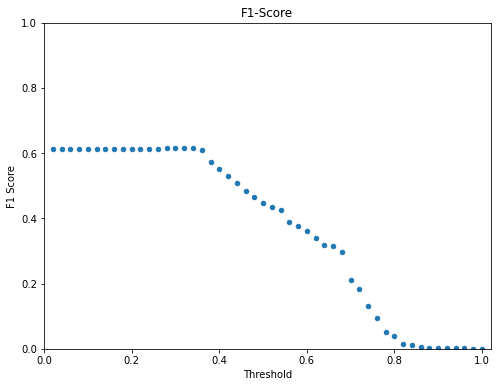

In [78]:
# Curva F1-Score

# Cria o plot
grap = df_results[df_results["threshold"] > 0.0].plot(kind="scatter", 
                                                         x="threshold", 
                                                         y="f1_score", 
                                                         grid=False, 
                                                         legend=True, 
                                                         title="F1-Score",
                                                         figsize=[8,6])
# Configurações do gráfico
grap.set(xlabel="Threshold", 
            ylabel="F1 Score", 
            xlim=(0.0,1.02), 
            ylim=(0.0,1.0))

# mostra o gráfico
plt.show()

Class report test
               precision    recall  f1-score   support

           0       0.57      0.04      0.08     69347
           1       0.44      0.96      0.60     54726

    accuracy                           0.45    124073
   macro avg       0.51      0.50      0.34    124073
weighted avg       0.52      0.45      0.31    124073



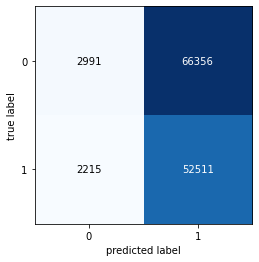


 Class report validation
               precision    recall  f1-score   support

           0       0.57      0.04      0.08     69347
           1       0.44      0.96      0.60     54726

    accuracy                           0.45    124073
   macro avg       0.51      0.50      0.34    124073
weighted avg       0.52      0.45      0.31    124073



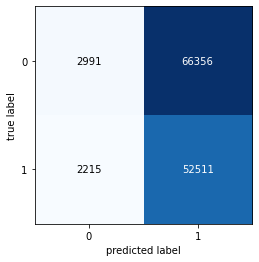

In [79]:
# prediction validation
y_proba_val = y_proba = model.predict_proba(X_validation)[:, 1]
# Cria a resposta com o novo threshold
y_pred_test = np.where(y_proba >= 0.32, 1, 0)
y_pred_val = np.where(y_proba_val >= 0.32, 1, 0)

# metrics
cr_test, cm_test = classification_report(y_test, y_pred_test), confusion_matrix(y_test, y_pred_test)
cr_val, cm_val = classification_report(y_test, y_pred_val), confusion_matrix(y_test, y_pred_val)
print('Class report test\n',cr_test)
plot_confusion_matrix(cm_test)
plt.show()

print('\n', 'Class report validation\n', cr_val)
plot_confusion_matrix(cm_val)

plt.show()

**Comments:** Using 0.32 as threshold a recall of 0.96 and f1-score of 0.6 were achieved.

##### KNN improvement

In [26]:
%%time
# parameter grid -> Due to the dataset's size train_size was descreased to only 10% of the total only for KNN optimization (test_size=0.9)
## n_neighbors 
n_neighbors = [x for x in range(1, 15, 2)]

## weights 
weights = ['uniform', 'distance']

## algorithm  
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

## leaf_size
leaf_size = [15, 30, 45]

## p for Minkowski metric. When p = 1, this is equivalent manhattan_distance (l1), and euclidean_distance (l2) for p = 2.
p = [1, 2, 4, 8]

## creating a random grid
param_distributions = {"n_neighbors":n_neighbors,
                       'weights':weights,
                       'algorithm':algorithm,
                       'leaf_size':leaf_size,
                       'p':p}

## model
model = KNeighborsClassifier()

## display
pprint(param_distributions)

## setting the randomized search
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_distributions,
                                   scoring='f1',
                                   n_iter=100, 
                                   cv=kfold, 
                                   verbose=5,
                                   n_jobs=-1,
                                   random_state=42)

# running test
random_search.fit(X_train, y_train)

{'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
 'leaf_size': [15, 30, 45],
 'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
 'p': [1, 2, 4, 8],
 'weights': ['uniform', 'distance']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 1h 57min 21s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
                   estimator=KNeighborsClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [15, 30, 45],
                                        'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
                                        'p': [1, 2, 4, 8],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='f1', verbose=5)

In [27]:
# summary table with results sorted from the best ranked parameters
table_results = pd.DataFrame(random_search.cv_results_)
table_results_sorted = table_results.sort_values(by='rank_test_score')
table_results_sorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_p,param_n_neighbors,param_leaf_size,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,0.399307,0.002625,162.020500,4.633774,uniform,8,7,45,ball_tree,"{'weights': 'uniform', 'p': 8, 'n_neighbors': ...",0.527838,0.481566,0.495610,0.501672,0.019370,1
34,0.277983,0.000817,16.984935,0.772133,uniform,1,7,45,auto,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.528114,0.480819,0.495785,0.501573,0.019737,2
90,0.167655,0.007134,32.545291,0.786218,uniform,2,7,45,ball_tree,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.526945,0.480966,0.495926,0.501279,0.019149,3
46,0.023332,0.001247,31.738675,0.404013,uniform,2,3,45,brute,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.510839,0.499062,0.491848,0.500583,0.007827,4
89,0.025334,0.002055,35.218125,0.236424,uniform,1,3,15,brute,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.510514,0.498795,0.492322,0.500544,0.007529,5


In [28]:
# mean scoring value
f1_score_random = random_search.cv_results_['mean_test_score']
mean_f1_score_random = f1_score_random[~np.isnan(f1_score_random)].mean()
print("Mean_F1_score: ", np.around(mean_f1_score_random, 2))
best_param_random = random_search.best_params_
print("Best parameters: ")
pprint(best_param_random)

Mean_F1_score:  0.49
Best parameters: 
{'algorithm': 'ball_tree',
 'leaf_size': 45,
 'n_neighbors': 7,
 'p': 8,
 'weights': 'uniform'}


In [29]:
%%time
# running KNN
model = KNeighborsClassifier(n_neighbors=7,
                             p=8,
                             algorithm='ball_tree',
                             leaf_size=45,
                             weights='uniform',
                             n_jobs=-1)
# fitting the model
model.fit(X_train, y_train)

# working out prediction
y_proba = model.predict_proba(X_test)[:, 1]
results_test = pd.DataFrame(zip(y_test, np.around(y_proba, 3)), columns=['target', 'proba'])
df_results = best_classification_split_score(results_test, threshold_increment=0.02,colum_probabilities='proba')

# organizing values on a dataframe
df_results.sort_values(by=['recall', 'precision', 'f1_score'], ascending=False)

#KNeighborsClassifier(weights='uniform', n_neighbors=9, metric='manhattan', algorithm='auto', n_jobs=-1)

0.02 0.04 0.06 0.08 0.1 0.12 0.14 0.16 0.18 0.2 0.22 0.24 0.26 0.28 0.3 0.32 0.34 0.36 0.38 0.4 0.42 0.44 0.46 0.48 0.5 0.52 0.54 0.56 0.58 0.6 0.62 0.64 0.66 0.68 0.7 0.72 0.74 0.76 0.78 0.8 0.82 0.84 0.86 0.88 0.9 0.92 0.94 0.96 0.98 1.0 Wall time: 11min 41s


,threshold,TN,FN,FP,TP,precision,recall,accuracy,f0_score,f1_score
0,0.02,3115,1181,121710,97325,0.4443,0.9880,0.4497,0.0482,0.6130
1,0.04,3115,1181,121710,97325,0.4443,0.9880,0.4497,0.0482,0.6130
2,0.06,3115,1181,121710,97325,0.4443,0.9880,0.4497,0.0482,0.6130
3,0.08,3115,1181,121710,97325,0.4443,0.9880,0.4497,0.0482,0.6130
4,0.10,3115,1181,121710,97325,0.4443,0.9880,0.4497,0.0482,0.6130
5,0.12,3115,1181,121710,97325,0.4443,0.9880,0.4497,0.0482,0.6130
6,0.14,3115,1181,121710,97325,0.4443,0.9880,0.4497,0.0482,0.6130
7,0.16,18114,9634,106711,88872,0.4544,0.9022,0.4790,0.2374,0.6044
8,0.18,18114,9634,106711,88872,0.4544,0.9022,0.4790,0.2374,0.6044
9,0.20,18114,9634,106711,88872,0.4544,0.9022,0.4790,0.2374,0.6044


**Comments:** Thresholds between 0.02 and 0.14 yielded the highest combinations of recall, precision and f1-score values.

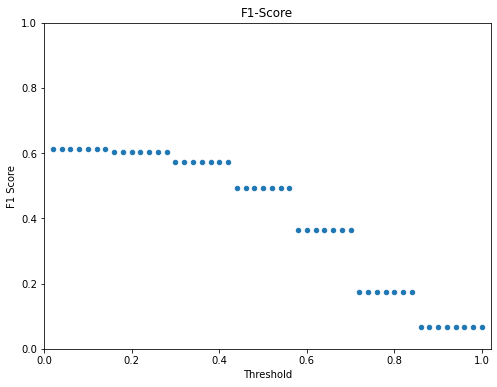

In [30]:
# Curva F1-Score

# Cria o plot
grap = df_results[df_results["threshold"] > 0.0].plot(kind="scatter", 
                                                         x="threshold", 
                                                         y="f1_score", 
                                                         grid=False, 
                                                         legend=True, 
                                                         title="F1-Score",
                                                         figsize=[8,6])
# Configurações do gráfico
grap.set(xlabel="Threshold", 
            ylabel="F1 Score", 
            xlim=(0.0,1.02), 
            ylim=(0.0,1.0))

# mostra o gráfico
plt.show()

Class report test
               precision    recall  f1-score   support

           0       0.56      0.02      0.04    124825
           1       0.44      0.98      0.61     98506

    accuracy                           0.44    223331
   macro avg       0.50      0.50      0.32    223331
weighted avg       0.51      0.44      0.29    223331



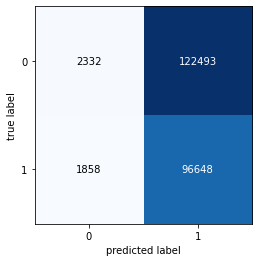


 Class report validation
               precision    recall  f1-score   support

           0       0.56      0.02      0.04    124825
           1       0.44      0.98      0.61     98506

    accuracy                           0.44    223331
   macro avg       0.50      0.50      0.32    223331
weighted avg       0.51      0.44      0.29    223331



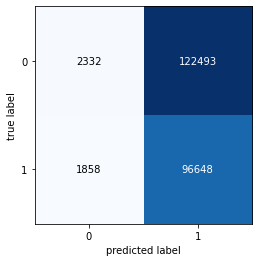

In [31]:
# prediction validation
y_proba_val = y_proba = model.predict_proba(X_validation)[:, 1]
# Cria a resposta com o novo threshold
y_pred_test = np.where(y_proba >= 0.1, 1, 0)
y_pred_val = np.where(y_proba_val >= 0.1, 1, 0)

# metrics
cr_test, cm_test = classification_report(y_test, y_pred_test), confusion_matrix(y_test, y_pred_test)
cr_val, cm_val = classification_report(y_test, y_pred_val), confusion_matrix(y_test, y_pred_val)
print('Class report test\n',cr_test)
plot_confusion_matrix(cm_test)
plt.show()

print('\n', 'Class report validation\n', cr_val)
plot_confusion_matrix(cm_val)

plt.show()

**Comments:** Using 0.10 as cutoff point, precision, recall and f1-score were all optimized to find positive individuals.

##### Gradient boosting classifier improvment

In [32]:
%%time
# parameter grid -> Due to the dataset's size train_size was descreased to only 10% of the total only for KNN optimization (test_size=0.9)
## learning_rate
learning_rate = [0.001, 0.01, 0.1]

## n_estimators
n_estimators = [100, 250, 500]

## min_samples_split
min_samples_split = [2, 3, 4]

## class min_samples_leaf 
min_samples_leaf = [1, 2, 4]

## max_depth 
max_depth = [2, 3, 5]

## creating a random grid
param_distributions = {"learning_rate":learning_rate,
                       'n_estimators': n_estimators,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf,
                       'max_depth': max_depth}

## model
model = GradientBoostingClassifier(random_state=42)

## display
pprint(param_distributions)

## setting the randomized search
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_distributions,
                                   scoring='f1',
                                   n_iter = 100, 
                                   cv = kfold, 
                                   verbose=5,
                                   n_jobs = -1,
                                   random_state=42)
# fitting
random_search.fit(X_train, y_train)

{'learning_rate': [0.001, 0.01, 0.1],
 'max_depth': [2, 3, 5],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 3, 4],
 'n_estimators': [100, 250, 500]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 26min 5s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
                   estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [2, 3, 5],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [100, 250, 500]},
                   random_state=42, scoring='f1', verbose=5)

In [33]:
# summary table with results sorted from the best ranked parameters
table_results = pd.DataFrame(random_search.cv_results_)
table_results_sorted = table_results.sort_values(by='rank_test_score')
table_results_sorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
84,33.674222,0.285527,0.275982,0.017569,500,4,2,3,0.1,"{'n_estimators': 500, 'min_samples_split': 4, ...",0.456526,0.448411,0.441201,0.448712,0.006260,1
58,52.978010,0.160643,0.420641,0.010872,500,4,1,5,0.1,"{'n_estimators': 500, 'min_samples_split': 4, ...",0.457829,0.446523,0.440136,0.448163,0.007316,2
11,34.236519,0.039039,0.263652,0.016111,500,2,4,3,0.1,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.454813,0.448980,0.440095,0.447962,0.006051,3
6,34.087529,0.289413,0.246986,0.002826,500,4,4,3,0.1,"{'n_estimators': 500, 'min_samples_split': 4, ...",0.454813,0.448980,0.440095,0.447962,0.006051,3
16,53.449646,0.149907,0.392977,0.022043,500,2,4,5,0.1,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.455057,0.448474,0.440050,0.447861,0.006142,5


In [34]:
# mean scoring value
f1_score_random = random_search.cv_results_['mean_test_score']
mean_f1_score_random = f1_score_random[~np.isnan(f1_score_random)].mean()
print("Mean_F1_score: ", np.around(mean_f1_score_random, 2))
best_param_random = random_search.best_params_
print("Best parameters: ")
pprint(best_param_random)

Mean_F1_score:  0.34
Best parameters: 
{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 500}


In [35]:
%%time
model = GradientBoostingClassifier(n_estimators=500,
                                   learning_rate=0.1,
                                   max_depth=3,
                                   min_samples_leaf=2,
                                   min_samples_split=4,
                                   random_state=42)
# fitting the model
model.fit(X_train, y_train)

# working out prediction
y_proba = model.predict_proba(X_test)[:, 1]
results_test = pd.DataFrame(zip(y_test, np.around(y_proba, 3)), columns=['target', 'proba'])
df_results = best_classification_split_score(results_test, threshold_increment=0.02,colum_probabilities='proba')

# organizing values on a dataframe
df_results.sort_values(by=['recall', 'f1_score'], ascending=False)

0.02 0.04 0.06 0.08 0.1 0.12 0.14 0.16 0.18 0.2 0.22 0.24 0.26 0.28 0.3 0.32 0.34 0.36 0.38 0.4 0.42 0.44 0.46 0.48 0.5 0.52 0.54 0.56 0.58 0.6 0.62 0.64 0.66 0.68 0.7 0.72 0.74 0.76 0.78 0.8 0.82 0.84 0.86 0.88 0.9 0.92 0.94 0.96 0.98 1.0 Wall time: 29.2 s


,threshold,TN,FN,FP,TP,precision,recall,accuracy,f0_score,f1_score
0,0.02,25,6,124800,98500,0.4411,0.9999,0.4412,0.0004,0.6122
1,0.04,41,18,124784,98488,0.4411,0.9998,0.4412,0.0007,0.6121
2,0.06,68,31,124757,98475,0.4411,0.9997,0.4412,0.0011,0.6121
3,0.08,120,48,124705,98458,0.4412,0.9995,0.4414,0.0019,0.6122
4,0.10,378,90,124447,98416,0.4416,0.9991,0.4424,0.0060,0.6125
5,0.12,988,195,123837,98311,0.4425,0.9980,0.4446,0.0157,0.6132
6,0.14,1534,312,123291,98194,0.4433,0.9968,0.4465,0.0242,0.6137
7,0.16,1623,345,123202,98161,0.4434,0.9965,0.4468,0.0256,0.6138
8,0.18,2188,467,122637,98039,0.4443,0.9953,0.4488,0.0343,0.6143
9,0.20,2284,495,122541,98011,0.4444,0.9950,0.4491,0.0358,0.6144


**Comments:** Thresholds of up to 0.3 yields the highest recall values. 0.3 was chosen because it rendered f1-score of 0.6160.

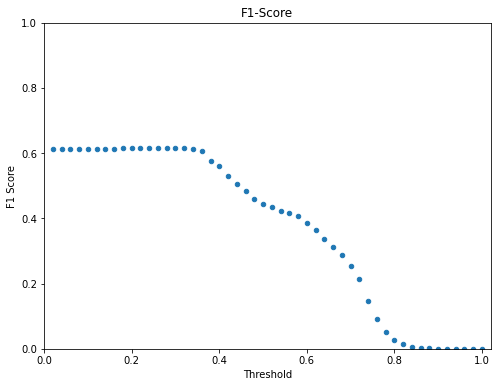

In [36]:
# Curva F1-Score

# Cria o plot
grap = df_results[df_results["threshold"] > 0.0].plot(kind="scatter", 
                                                         x="threshold", 
                                                         y="f1_score", 
                                                         grid=False, 
                                                         legend=True, 
                                                         title="F1-Score",
                                                         figsize=[8,6])
# Configurações do gráfico
grap.set(xlabel="Threshold", 
            ylabel="F1 Score", 
            xlim=(0.0,1.02), 
            ylim=(0.0,1.0))

# mostra o gráfico
plt.show()

Class report test
               precision    recall  f1-score   support

           0       0.56      0.04      0.07    124825
           1       0.44      0.96      0.60     98506

    accuracy                           0.45    223331
   macro avg       0.50      0.50      0.34    223331
weighted avg       0.51      0.45      0.31    223331



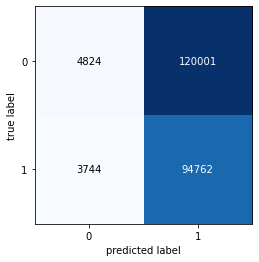


 Class report validation
               precision    recall  f1-score   support

           0       0.56      0.04      0.07    124825
           1       0.44      0.96      0.60     98506

    accuracy                           0.45    223331
   macro avg       0.50      0.50      0.34    223331
weighted avg       0.51      0.45      0.31    223331



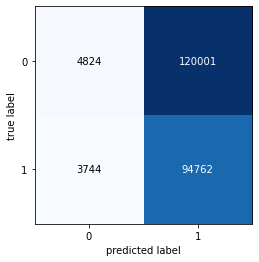

In [37]:
# prediction validation
y_proba_val = y_proba = model.predict_proba(X_validation)[:, 1]
# Cria a resposta com o novo threshold
y_pred_test = np.where(y_proba >= 0.3, 1, 0)
y_pred_val = np.where(y_proba_val >= 0.3, 1, 0)

# metrics
cr_test, cm_test = classification_report(y_test, y_pred_test), confusion_matrix(y_test, y_pred_test)
cr_val, cm_val = classification_report(y_test, y_pred_val), confusion_matrix(y_test, y_pred_val)
print('Class report test\n',cr_test)
plot_confusion_matrix(cm_test)
plt.show()

print('\n', 'Class report validation\n', cr_val)
plot_confusion_matrix(cm_val)

plt.show()

**Comments:** A large amount of the true positives were identified using the parameters above.

## Conclusions

- This dataset didn't provide a clear way to achieve high precision and recall for both negative and positive values.
- Given the nature of COVID-19 infection and the threat posed by non-diagnosed, infected people roaming free among the others, we opted for increasing the detection ratio in positive individuals, even though a consequent increase in the ratio of false positives came as a side-effect.
- A series of threshold was tested and those which yielded the highest recall and precision values for category 1 were chosen. Models were optimized through random grid search to find the best parameters in order to achieve our goals. As a result:
 - KNN, Decision Tree and Gradient Boosting classifier provided the best results.
 - It's noteworthy that Logistic Regression also performed very well and, given the simplicity and explainability of this model, could be used. 
- AdaBoost classifier seems to have overfitted and mustn't be considered for use.